In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col, udf, array_join
from pyspark.sql.types import StringType
import html
import re

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Load CSV file into DataFrame
file_path = "/FileStore/tables/cleaned_youtube_comments.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Inspect the schema of the DataFrame
df.printSchema()

# Function to clean HTML tags and decode characters
def clean_comment(comment):
    if comment is None:
        return ""
    # Decode HTML entities
    comment = html.unescape(comment)
    # Remove HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    return comment

# Register UDF
clean_comment_udf = udf(clean_comment, StringType())

# Apply UDF to clean comments
df_cleaned = df.withColumn("cleaned_comment", clean_comment_udf(col("comment"))).cache()

# Tokenization
tokenizer = Tokenizer(inputCol="cleaned_comment", outputCol="words")
wordsData = tokenizer.transform(df_cleaned).cache()

# Stop word removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filteredData = remover.transform(wordsData).cache()

# Join the elements of the array into a single string
finalData = filteredData.withColumn("filtered_words_str", array_join(col("filtered_words"), " ")).cache()

# Remove duplicates in the final DataFrame
finalDataDistinct = finalData.dropDuplicates()

# Define output path
output_path = "/FileStore/tables/processed_youtube_comments.csv"

# Remove existing directory if exists
try:
    dbutils.fs.rm(output_path, recurse=True)
except Exception as e:
    print(f"Error removing existing directory: {e}")

# Save processed data to CSV
try:
    finalDataDistinct.select("author", "comment", "filtered_words_str", "published_at").write.mode("overwrite").csv(output_path, header=True)
    print("Data saved successfully.")
except Exception as e:
    print(f"Error writing data to CSV: {e}")

# Verify record counts at each stage
initial_count = df.count()
cleaned_count = df_cleaned.count()
tokenized_count = wordsData.count()
filtered_count = filteredData.count()
final_count = finalDataDistinct.count()

print(f"Initial record count: {initial_count}")
print(f"Record count after cleaning: {cleaned_count}")
print(f"Record count after tokenization: {tokenized_count}")
print(f"Record count after stop word removal: {filtered_count}")
print(f"Final distinct record count: {final_count}")


root
 |-- author: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- published_at: string (nullable = true)

Data saved successfully.
Initial record count: 314
Record count after cleaning: 314
Record count after tokenization: 314
Record count after stop word removal: 314
Final distinct record count: 314


In [0]:
pip install nltk

Python interpreter will be restarted.
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)
  Using cached regex-2024.5.15-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (774 kB)
Python interpreter will be restarted.


In [0]:
processed_file_path = "/FileStore/tables/processed_youtube_comments.csv"
processed_df = spark.read.csv(processed_file_path, header=True, inferSchema=True)

# Display the schema and a few rows to verify the data
processed_df.printSchema()
processed_df.show(5)

# Import necessary libraries for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to classify sentiment
def analyze_sentiment(text):
    if text is None:
        return "neutral"
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return "positive"
    elif scores['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Register the function as a UDF
analyze_sentiment_udf = udf(analyze_sentiment, StringType())

# Apply the UDF to classify sentiment
sentiment_df = processed_df.withColumn("sentiment", analyze_sentiment_udf(col("filtered_words_str")))

# Show some examples
sentiment_df.select("author", "comment", "filtered_words_str", "sentiment").show(5)

# Group by sentiment and count the occurrences
sentiment_counts = sentiment_df.groupBy("sentiment").count()

# Show the aggregated result
sentiment_counts.show()

root
 |-- author: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- filtered_words_str: string (nullable = true)
 |-- published_at: string (nullable = true)

+-----------------+--------------------+--------------------+--------------------+
|           author|             comment|  filtered_words_str|        published_at|
+-----------------+--------------------+--------------------+--------------------+
|@KhushiKhan-mx4qm|A🌌✨🥺🌙😭😭😭😭?...|a🌌✨🥺🌙😭😭😭😭?...|2023-02-06T17:00:21Z|
|       @MUXZAMMIL|Ye panotii kon ha...|ye panotii kon ha...|2021-12-27T16:04:31Z|
|      @EjajSayyad|           9.20 😁😁|           9.20 😁😁|2021-09-29T11:10:15Z|
|  @ravisolanki324|"<a href=""https:...|     "5:26 😂😂😂😂"|2024-03-30T04:02:05Z|
|    @royalboy3081|               Hello|               hello|2021-11-15T13:45:02Z|
+-----------------+--------------------+--------------------+--------------------+
only showing top 5 rows



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+-----------------+--------------------+--------------------+---------+
|           author|             comment|  filtered_words_str|sentiment|
+-----------------+--------------------+--------------------+---------+
|@KhushiKhan-mx4qm|A🌌✨🥺🌙😭😭😭😭?...|a🌌✨🥺🌙😭😭😭😭?...|  neutral|
|       @MUXZAMMIL|Ye panotii kon ha...|ye panotii kon ha...| positive|
|      @EjajSayyad|           9.20 😁😁|           9.20 😁😁|  neutral|
|  @ravisolanki324|"<a href=""https:...|     "5:26 😂😂😂😂"|  neutral|
|    @royalboy3081|               Hello|               hello|  neutral|
+-----------------+--------------------+--------------------+---------+
only showing top 5 rows

+---------+-----+
|sentiment|count|
+---------+-----+
| positive|   73|
|  neutral|  226|
| negative|   15|
+---------+-----+



In [0]:
%pip install matplotlib seaborn

Python interpreter will be restarted.
Python interpreter will be restarted.


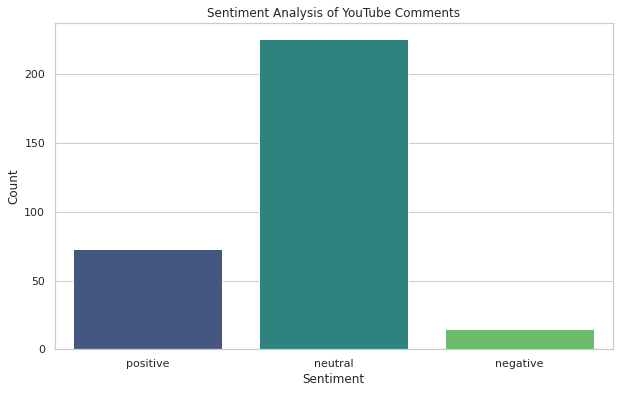

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the sentiment counts DataFrame to a Pandas DataFrame for easier plotting
sentiment_counts_pd = sentiment_counts.toPandas()

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for sentiment counts
plt.figure(figsize=(10, 6))
sns.barplot(x="sentiment", y="count", data=sentiment_counts_pd, palette="viridis")
plt.title("Sentiment Analysis of YouTube Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


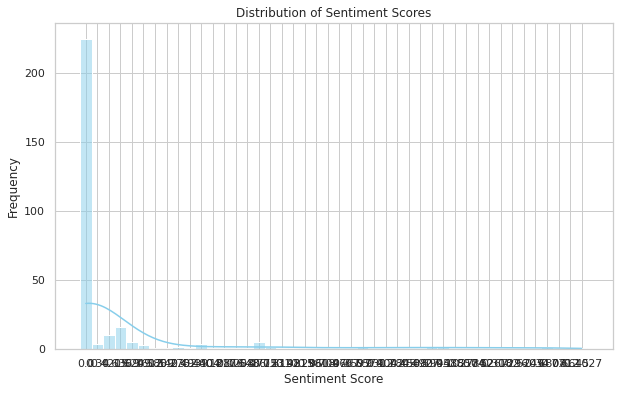

In [0]:
# Create a new column for sentiment scores
def get_sentiment_score(text):
    if text is None:
        return 0.0
    scores = sid.polarity_scores(text)
    return scores['compound']

get_sentiment_score_udf = udf(get_sentiment_score, StringType())

# Add sentiment score column to the DataFrame
sentiment_df = sentiment_df.withColumn("sentiment_score", get_sentiment_score_udf(col("filtered_words_str")))

# Convert to Pandas DataFrame
sentiment_scores_pd = sentiment_df.select("sentiment_score").toPandas()

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_scores_pd["sentiment_score"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()
